In [1]:
import csv
import os
import time
from urllib.request import urlopen

from PIL import Image
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import vk_api
from tqdm import tqdm

In [2]:
load_dotenv()
TOKEN=os.getenv('TOKEN')
MY_USER_ID=os.getenv('MY_USER_ID')

In [3]:

vk_session = vk_api.VkApi(token=TOKEN)
vk = vk_session.get_api()

In [4]:
friends_response = vk.friends.get(user_id=MY_USER_ID)
friends_response

{'count': 678,
 'items': [25168,
  25244,
  30817,
  67341,
  203251,
  220072,
  241044,
  250674,
  276308,
  278301,
  307685,
  341135,
  358387,
  385125,
  438646,
  451958,
  490434,
  515201,
  550393,
  578995,
  654310,
  666436,
  718317,
  780960,
  791551,
  807635,
  848668,
  880518,
  895583,
  902967,
  939604,
  956852,
  1025204,
  1162306,
  1247733,
  1355949,
  1493725,
  1500142,
  1554549,
  1639442,
  1657984,
  1704386,
  1747883,
  1785612,
  1792593,
  1863433,
  1929132,
  1936125,
  1974229,
  1996745,
  2208815,
  2240791,
  2245876,
  2347118,
  2447361,
  2482450,
  2484141,
  2509691,
  2550295,
  2599794,
  2612212,
  2720714,
  2739036,
  2758712,
  2797712,
  2946860,
  2972115,
  3057581,
  3067018,
  3069619,
  3082139,
  3088423,
  3125825,
  3146738,
  3170996,
  3402139,
  3440316,
  3442105,
  3445658,
  3482626,
  3498216,
  3508411,
  3551884,
  3566164,
  3789532,
  3914635,
  3935619,
  3940488,
  4102414,
  4152416,
  4165372,
  4203991,


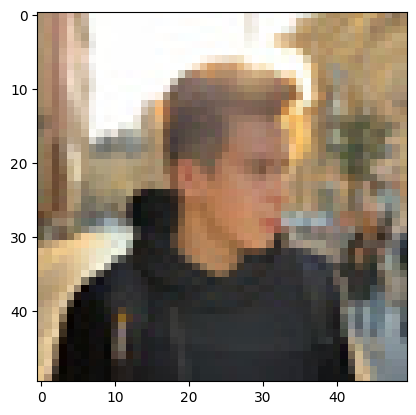

In [5]:
url = 'https://sun1-29.userapi.com/s/v1/if1/uvUBz8r03GfU0-d_q82W0J-PhvH0Ibv73ctNK1uTEUuFjkfDpIZO-ABpRV8lnT_OyqWdwg.jpg?size=50x50&quality=96&crop=0,57,1218,1218&ava=1'

response = urlopen(url)
img = Image.open(response)
img = np.asarray(img, dtype=np.int64)

plt.imshow(img, vmin=0, vmax=255)

[0, 1, 2, 3, 4, 5]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]


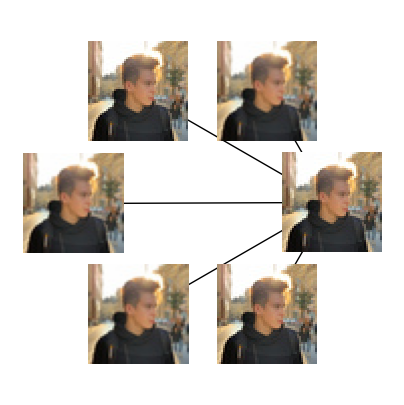

In [6]:
G=nx.Graph()
G.add_node(0, image=img)
G.add_node(1, image=img)
G.add_node(2, image= img)
G.add_node(3, image= img)
G.add_node(4, image= img)
G.add_node(5, image= img)

print(G.nodes())
G.add_edge(0,1)
G.add_edge(0,2)
G.add_edge(0,3)
G.add_edge(0,4)
G.add_edge(0,5)
print(G.edges())
pos=nx.circular_layout(G)

fig=plt.figure(figsize=(5,5))
ax=plt.subplot(111)
ax.set_aspect('equal')
nx.draw_networkx_edges(G,pos,ax=ax)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.2 # this is the image size
p2=piesize/2.0
for n in G:
    xx,yy=trans(pos[n]) # figure coordinates
    xa,ya=trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-p2,ya-p2, piesize, piesize])
    a.set_aspect('equal')
    a.imshow(G.nodes[n]['image'])
    a.axis('off')
ax.axis('off')
plt.show()

In [7]:
PHOTO_50 = 'photo_50'
SEX = 'sex'
BDATE = 'bdate'
ITEMS = 'items'
ID = 'id'
FIRST_NAME = 'first_name'
LAST_NAME = 'last_name'

In [8]:
import pickle
import concurrent
import urllib3

def get_friends(source_id=MY_USER_ID, fields=(PHOTO_50, SEX, BDATE)):
    try:
        friends_response = vk.friends.get(user_id=source_id, fields=fields)
    except:
        return []
    return friends_response[ITEMS]


def get_friends_concurrent(friends_ids, target_friends_callback):
    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        future_to_id = {executor.submit(get_friends, friend_id): friend_id for friend_id in friends_ids}
        for future in tqdm(concurrent.futures.as_completed(future_to_id), total=len(friends_ids)):
            source_id = future_to_id[future]
            try:
                target_friends = future.result()
                target_friends_callback(source_id, target_friends)
            except Exception as exc:
                print('%r generated an exception: %s' % (source_id, exc))
                raise


In [9]:
from typing import List


def enrich_graph_with_friends(G, friends, source_id=MY_USER_ID, mutual_only=False, nodes_set=None) -> List[int]:
    friends_ids = []

    for friend in friends:
        id_ = friend[ID]
        if mutual_only:
            if id_ not in nodes_set:
                continue
        friends_ids.append(id_)
        G.add_node(id_, **friend)
        G.add_edge(source_id, id_)

    return friends_ids

In [10]:
def enrich_graph_with_friends_concurrent(G, friends, mutual_only=False, nodes_set=None):
    def target_friends_callback(source_id, target_friends):
        return enrich_graph_with_friends(G, target_friends, source_id, mutual_only, nodes_set)

    get_friends_concurrent(friends, target_friends_callback=target_friends_callback)

In [11]:
G = nx.DiGraph()
friends_ids = enrich_graph_with_friends(G, get_friends())

In [12]:
nodes_set = set(G.nodes)
enrich_graph_with_friends_concurrent(G, friends=friends_ids, mutual_only=True, nodes_set=nodes_set)


100%|██████████| 678/678 [13:51<00:00,  1.23s/it]


In [18]:
import pickle

pickle.dump(G, open('graph.pickle', 'wb'))

# G = pickle.load(open('graph.pickle', 'rb'))

In [19]:
len(G.edges)

49040

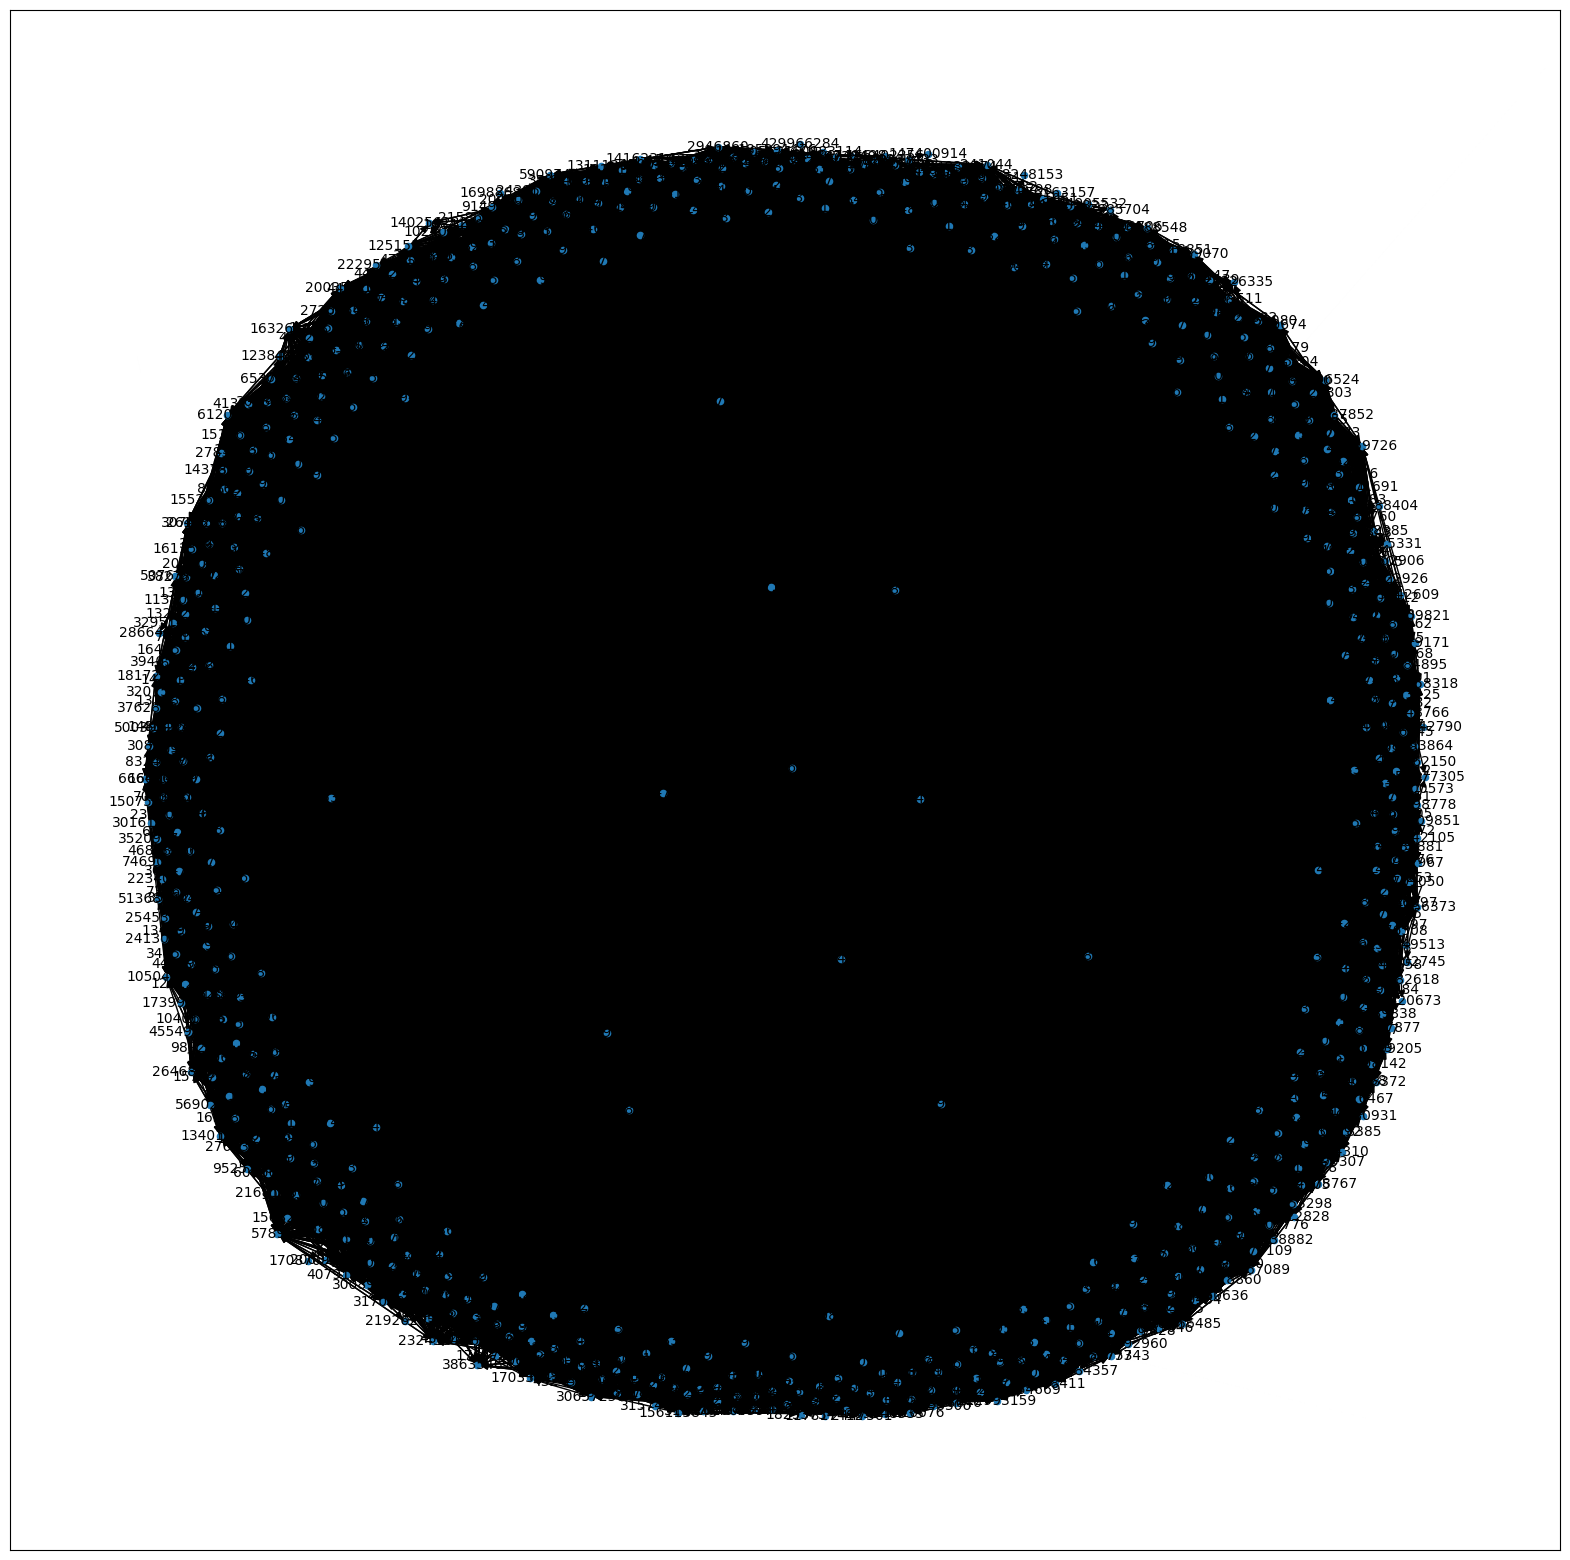

In [14]:
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k=5)
nx.draw_networkx(
    G,
    pos=pos,
    font_size=10,
    node_size=20,
)

In [379]:
G = pickle.load(open('graph.pickle', 'rb'))

In [380]:
UG = G.to_undirected()

In [381]:
DG = UG.copy()

In [382]:
DG.remove_node(MY_USER_ID)

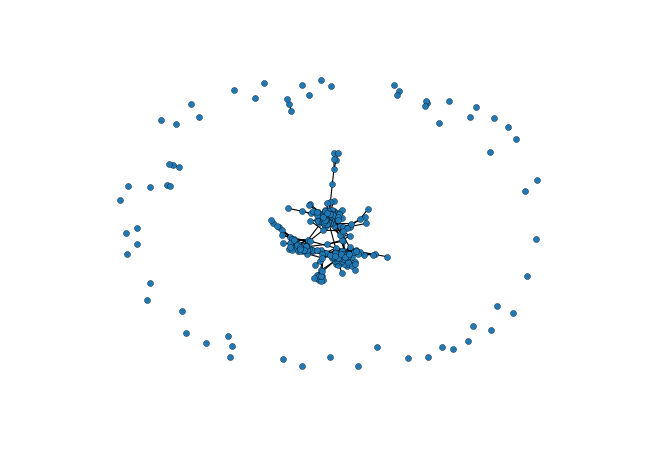

In [383]:
nx.draw(DG, node_size=30)

In [88]:
giant_component = max(nx.connected_components(DG), key=len)
GG = DG.subgraph(giant_component)

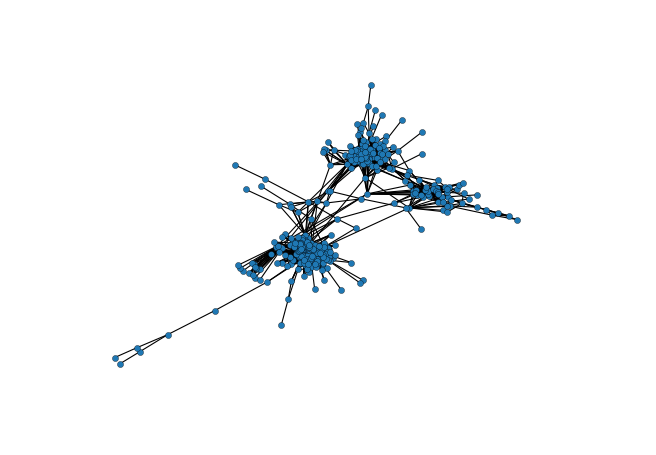

In [163]:
nx.draw(GG, node_size=30)

# Radius and diameter

In [64]:
r = nx.radius(GG)
r

6

In [38]:
d = nx.diameter(GG)
d

11

How about six degrees of separation?

# Clustering Coefficients

In [42]:
ac = nx.average_clustering(GG)
ac

0.5232456682800667

In [78]:
threshold = 2
G_friends_min = GG.subgraph([i for i in GG.nodes if GG.degree[i] > threshold])
len(G_friends_min.nodes)

562

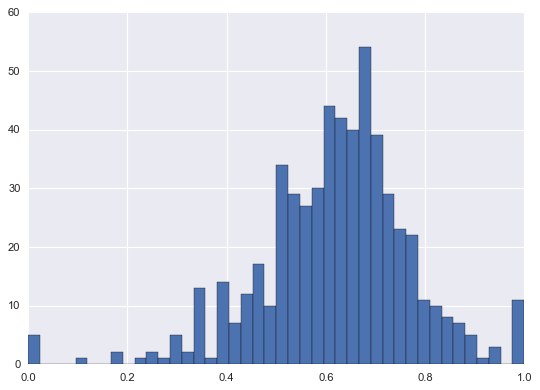

In [161]:
plt.hist(nx.clustering(G_friends_min).values(), bins=42)
None

In [83]:
print(f'Global clustering = {nx.transitivity(GG):.2f} (number of closed triplets / all triplets)')


Global clustering = 0.61 (number of closed triplets / all triplets)


# Path lengths

In [89]:
nx.average_shortest_path_length(GG)

3.1895371350940813

In [ ]:
pl = list(nx.all_pairs_shortest_path_length(GG))

In [115]:
lengths = []
for p in pl:
    src, targets = p
    for j in targets.values():
        lengths.append(j)

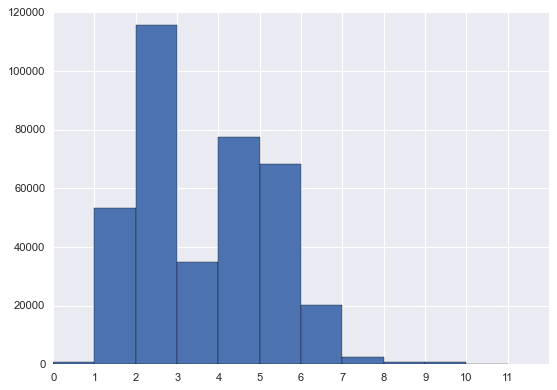

In [139]:
np.histogram(lengths)
n, bins, patches = plt.hist(lengths, bins=np.max(lengths))
plt.xticks(bins)
plt.show()

# Degree distribution

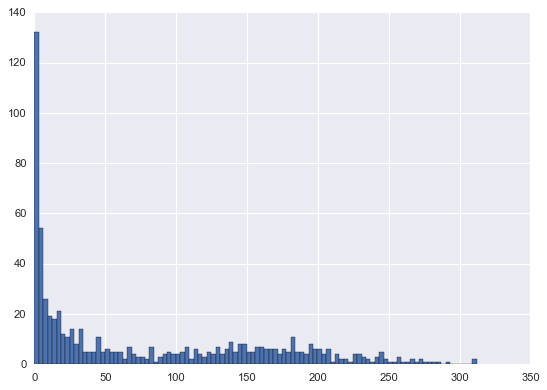

In [157]:
plt.hist(np.array(DG.degree)[:,1], bins=100)
plt.show()

In [193]:
from scipy import stats
def power_law_cdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / np.power(float(x_min), (1 - alpha))
    return 1 + (C * np.power(np.array(x).astype(float), (-alpha)) * x / (-alpha + 1))

def mle_power_law_params(degree_sequence, threshold=275):
    r = {}
    ds = degree_sequence.copy()
    idgr = list(map(int, degree_sequence))

    degree_sequence = np.array(degree_sequence)

    for x_min in sorted(set(idgr)):
        degree_sequence = degree_sequence[np.where(degree_sequence > x_min)]
        n = len(degree_sequence)
        if n < threshold:
          continue

        alpha = 1 + n / np.sum(np.log((degree_sequence/x_min)))

        result = stats.kstest(
            degree_sequence,
            # power_law_generate(n, alpha, x_min),
            power_law_cdf,
            args=(alpha, x_min),
            mode='approx',
            # alternative='less',
            N=n
            )
        # result = stats.ks_2samp(
        #     degree_sequence,
        #     power_law_generate(n, alpha, x_min),
        # )
        r[alpha, x_min] = result

        # if x_min % 10 == 0:
        # plt.figure()
        # plt.title(f'alpha={alpha} x_min={x_min}, result={result}')
        # plt.hist(degree_sequence, bins=100, cumulative=True)
        # plt.hist(power_law_cdf(np.linspace(1, 10, 100), alpha=alpha, x_min=x_min), bins=100, cumulative=True)
        # plt.hist(power_law_generate(n, alpha=alpha, x_min=x_min), bins=100)
        # print('alpha, x_min', alpha, x_min, result)

    # print(r.items())
    r = filter(lambda item: not (np.isnan(item[1].pvalue) or np.isnan(-item[1].statistic)), r.items())
    (alpha, x_min), res = max(r, key=lambda item: (item[1].pvalue, -item[1].statistic))
    print('best', alpha, x_min, res)
    # plt.figure()
    # plt.plot(list((item[1].pvalue, item[1].statistic) for item in r.items()))
    # plt.legend()
    # plt.figure()
    # plt.title(f'alpha={alpha} x_min={x_min}, result={result}')
    # ds = ds[np.where(ds > x_min)]
    # plt.hist(ds, bins=100, alpha=0.3)
    # plt.hist(power_law_generate(len(ds), alpha=alpha, x_min=x_min), bins=100, alpha=0.3)
    return alpha, x_min

def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / np.power(x_min, (1 - alpha))
    return C * np.power(x, -alpha)

In [210]:
degree_sequence = np.array(nx.degree_histogram(DG))
alpha, x_min = mle_power_law_params(degree_sequence, threshold=10)
alpha, x_min

best 2.314809134973535 6 KstestResult(statistic=0.1834594642004872, pvalue=0.6067220089692776)


/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_13859/2531156369.py:19: RuntimeWarning: divide by zero encountered in divide
  alpha = 1 + n / np.sum(np.log((degree_sequence/x_min)))
/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_13859/2531156369.py:4: RuntimeWarning: invalid value encountered in divide
  return 1 + (C * np.power(np.array(x).astype(float), (-alpha)) * x / (-alpha + 1))


(2.314809134973535, 6)

best 2.314809134973535 6 KstestResult(statistic=0.1834594642004872, pvalue=0.6067220089692776)


/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_13859/2531156369.py:19: RuntimeWarning: divide by zero encountered in divide
  alpha = 1 + n / np.sum(np.log((degree_sequence/x_min)))
/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_13859/2531156369.py:4: RuntimeWarning: invalid value encountered in divide
  return 1 + (C * np.power(np.array(x).astype(float), (-alpha)) * x / (-alpha + 1))


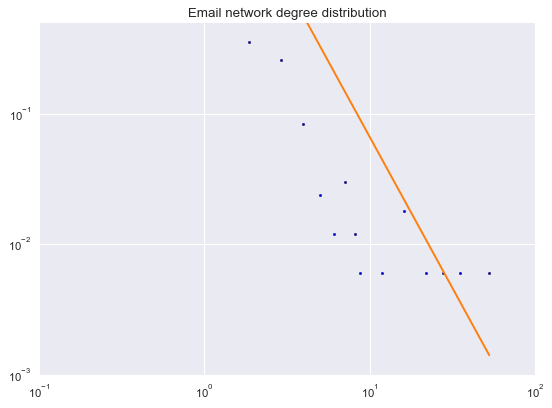

In [223]:
awhist, bin_edges = np.histogram(degree_sequence, bins=100, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
hist, bin_edges = np.histogram(degree_sequence, bins=100, density=True)
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('VK network degree distribution')

hat_alpha, hat_x_min = mle_power_law_params(degree_sequence, threshold=10)
x_space = np.linspace(2, degree_sequence.max(), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min),
         label='Estimated PDF', c='tab:orange')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.001, 0.5);

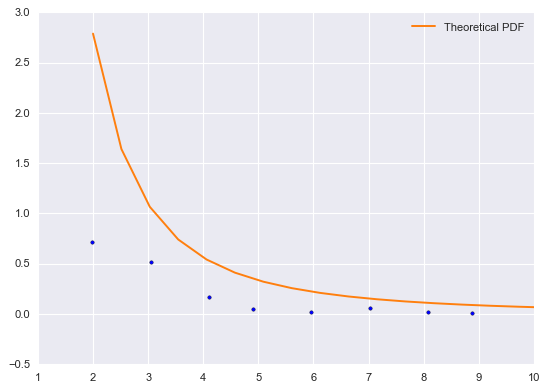

In [224]:
hist, bin_edges = np.histogram(degree_sequence, bins=200, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=10)
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min),
         label='Theoretical PDF', c='tab:orange')
plt.legend()
plt.xlim(1, 10)
plt.show()

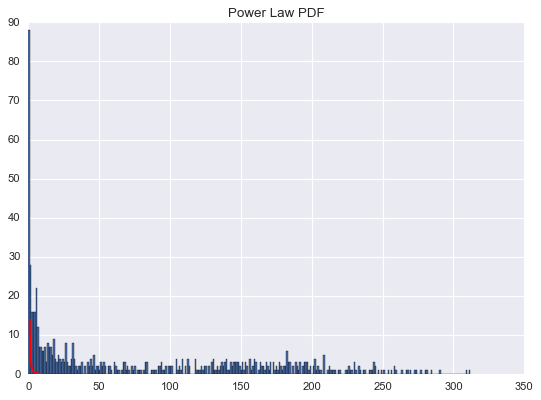

In [248]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / np.power(x_min, (1 - alpha))
    return C * np.power(x, -alpha)

x_space = np.linspace(1, 10, 100)
plt.title('Power Law PDF')
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min), c='r')
plt.hist(np.array(DG.degree)[:,1], bins=300)
plt.show()

# Gorgeous layout

## By sex

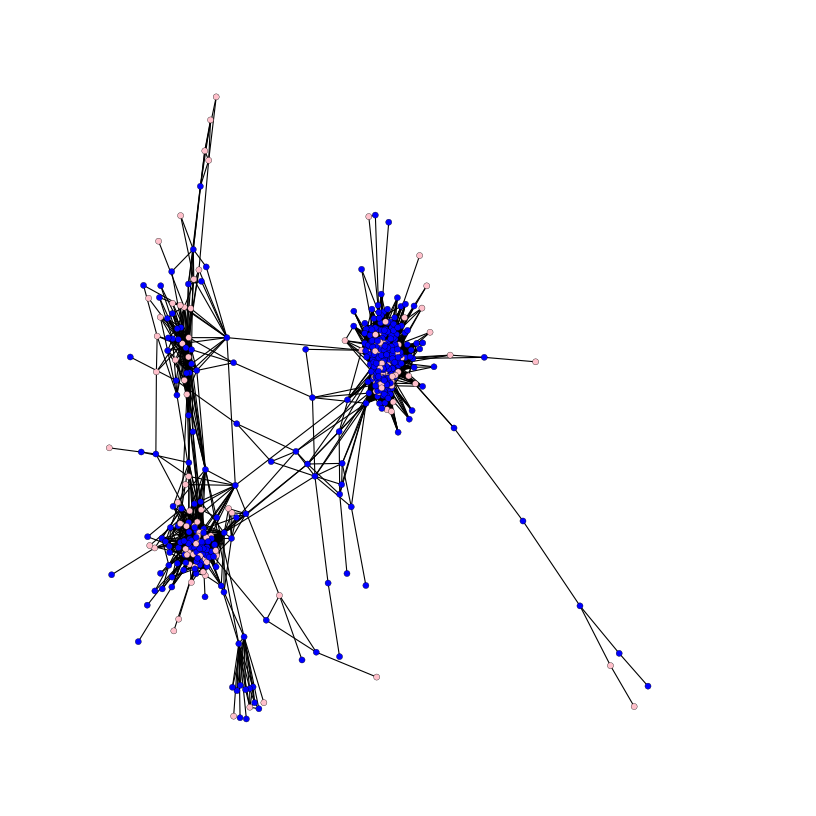

In [269]:
fig = plt.figure(figsize=(10,10))
color_map = []
for node in GG:
    if G.nodes[node]['sex'] == 1:
        color_map.append('pink')
    else:
        color_map.append('blue')

nx.draw(GG, node_size=30, node_color=color_map,
        # pos=nx.kamada_kawai_layout(GG)
        )

## By common friend count

NetworkXError: The node 1 is not in the graph.

In [325]:
def get_weight(G, node1, node2):
    nbs1 = set(G.neighbors(node1))
    nbs2 = set(G.neighbors(node2))

    return len(nbs1.intersection(nbs2))


def get_widths_by_common_friend(G):
    edges = G.edges()

    weights = []
    for u, v in edges:
        w = get_weight(G, u, v)
        weights.append(w)

    return weights

weights = get_widths_by_common_friend(GG)
weights = np.array(weights)

In [351]:
from datetime import datetime, date


def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def get_node_sizes_by_age(G):
    ages = {}
    for node in G:
        # print(f'>>> {G.nodes[node]}')
        bdate = G.nodes[node].get('bdate', 0)
        # print(f'>>> {bdate}')
        try:
            born = datetime.strptime(bdate, "%d.%m.%Y")
            age = calculate_age(born)
            ages[node] = age
        except:
            ages[node] = None

    for node in G:
        neighbors = G.neighbors(node)
        neighbors_ages = []
        for neighbor in neighbors:
            neighbor_age = ages[neighbor]
            if neighbor_age is not None:
                neighbors_ages.append(neighbor_age)
        if len(neighbors_ages) == 0:
            continue
        mean_age = np.mean(neighbors_ages)
        ages[node] = mean_age

    result_ages = []
    for node in G:
        age = ages[node]
        if age is None:
            age = 0
        result_ages.append(age)
    result_ages = np.array(result_ages)
    return result_ages

node_sizes = get_node_sizes_by_age(GG)

In [352]:
color_map = []
for node in GG:
    if G.nodes[node]['sex'] == 1:
        color_map.append('pink')
    else:
        color_map.append('blue')

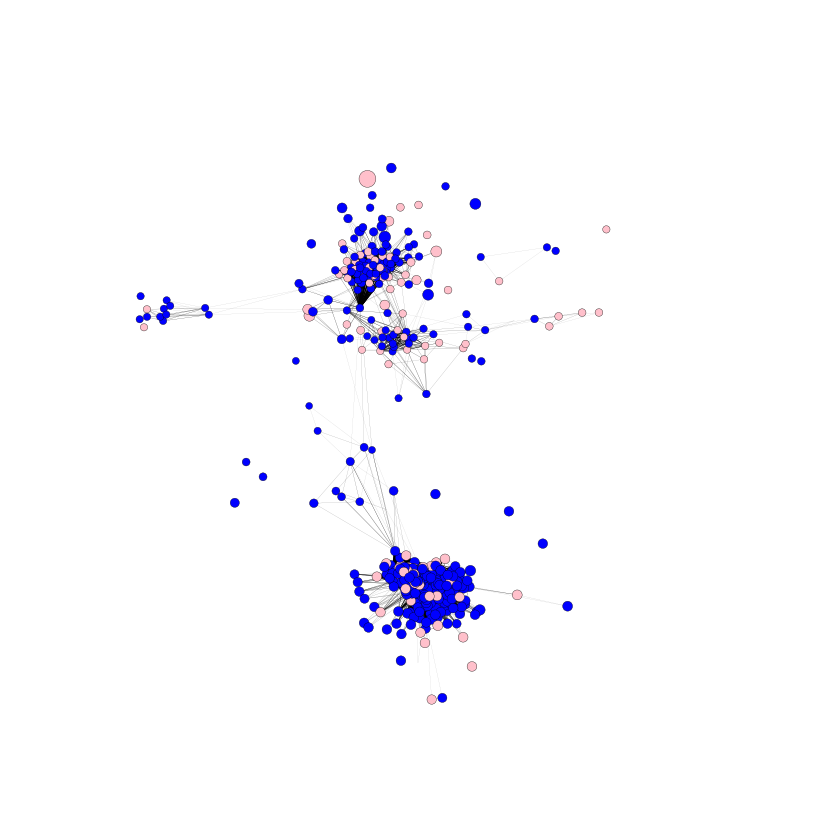

In [363]:

fig = plt.figure(figsize=(10,10))

nx.draw(GG, node_size=node_sizes*2, node_color=color_map, width=weights/weights.max()*10,
        # pos=nx.kamada_kawai_layout(GG),
        # pos=nx.circular_layout(GG),
        )

In [359]:
node_sizes.mean()

33.15512429116173

In [384]:
import csv

def dump_graph(G, path='edges.csv'):
    with open(path, 'w', newline='') as csvfile:
        fieldnames = ['source', 'target', 'weight']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        writer.writerows([{"source":u, "target":v, "weight":w} for (u, v), w in zip(G.edges, weights)])

dump_graph(UG)

In [385]:
!head edges.csv

source,target,weight
25168,25244,137
25168,67341,69
25168,203251,115
25168,220072,98
25168,250674,121
25168,276308,136
25168,307685,164
25168,385125,140
25168,490434,115


In [388]:
len(list(UG.neighbors(MY_USER_ID)))

678

In [422]:
UG.nodes[9158973]

{'id': 9158973,
 'bdate': '18.9',
 'track_code': '9086c18aOhKPNGpyKiBbZqtg4am2zJhMbbA6cktv5IIxiMhxr65Udd4-XhZwJ1xmWFUGSzkj6TVusFMXJQs',
 'sex': 2,
 'photo_50': 'https://sun1-93.userapi.com/s/v1/ig2/Kv08iF04iEhCVLBTqN31WyMEjcnnspOPX3GZFWJ_OICWw-PrB4bZI74HueihsXeWAoD7JbGZnIkJ1P2P1dzbWMGr.jpg?size=50x50&quality=96&crop=119,61,1483,1483&ava=1',
 'first_name': 'Artem',
 'last_name': 'Garaschenko',
 'can_access_closed': True,
 'is_closed': False,
 'lists': [27]}

# The closest random graph model similar to my social network

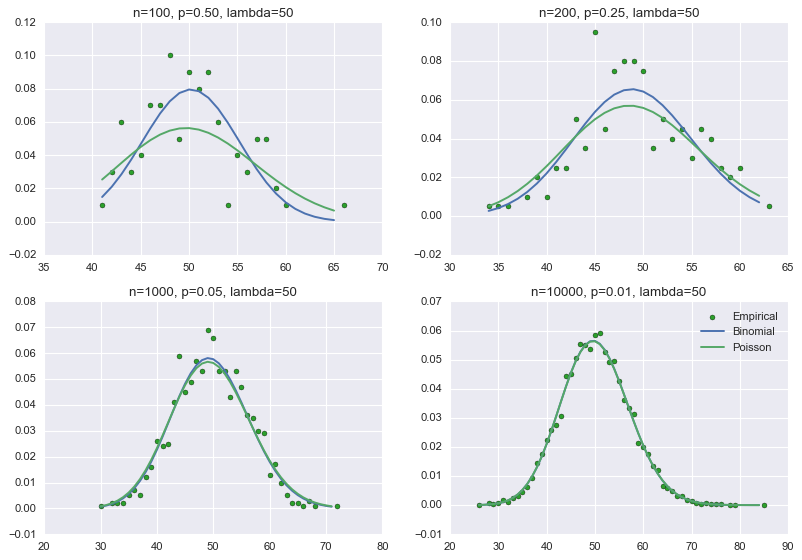

In [424]:
import scipy.stats as st

def erdos_renyi_graph(n, p):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_edges(nodes, p))
    return G

import itertools

def random_edges(nodes, p):
    mask = np.random.choice(a=[True, False], size=len(nodes)**2, p=[p, 1-p])
    pairs = itertools.combinations(nodes, 2)
    return np.array([(p1,p2) for (p1,p2), m in zip(pairs, mask) if m and p1!=p2])

def estimate_binomial(G):
    n = len(G.nodes)
    p = np.mean(list(dict(nx.degree(G)).values()))
    return n, p/n

def estimate_poisson(G):
    mean = np.mean(list(dict(nx.degree(G)).values()))
    return mean

plt.figure(figsize=[12, 8])
for i, [n, p] in enumerate([[100, 0.5], [200, 0.25], [1000, 0.05], [10000, 0.005]]):
    plt.subplot(2, 2, i+1)
    G = erdos_renyi_graph(n, p)
    degree_density = np.array(nx.degree_histogram(G)) / n
    idx = np.argwhere(degree_density > 0)
    plt.scatter(idx, degree_density[idx], label="Empirical", c='tab:green', s=20)
    degrees = dict(G.degree).values()
    k_space = np.arange(min(degrees), max(degrees))
    plt.plot(k_space, st.binom(*estimate_binomial(G)).pmf(k_space), label="Binomial")
    plt.plot(k_space, st.poisson(estimate_poisson(G)).pmf(k_space), label="Poisson")
    plt.title(f'n={n}, p={p:.2f}, lambda={n*p:.0f}')
plt.legend()
plt.show()

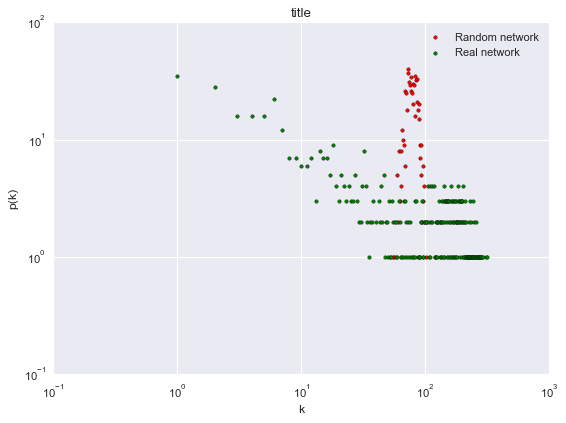

In [428]:
def random_from_real(graph):
    n, p = estimate_binomial(graph)
    return erdos_renyi_graph(n, p)

plt.figure()
real_net = DG
random_net = random_from_real(real_net)
degree_hist = np.array(nx.degree_histogram(random_net))
idx = np.argwhere(degree_hist > 0)
plt.scatter(idx, degree_hist[idx], s=10, label='Random network', c='r')
degree_hist = np.array(nx.degree_histogram(real_net))
idx = np.argwhere(degree_hist > 0)
plt.scatter(idx, degree_hist[idx], s=10, label='Real network', c='g')
plt.legend()
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('VK net vs ER random')
plt.xscale('log')
plt.yscale('log')
plt.show()

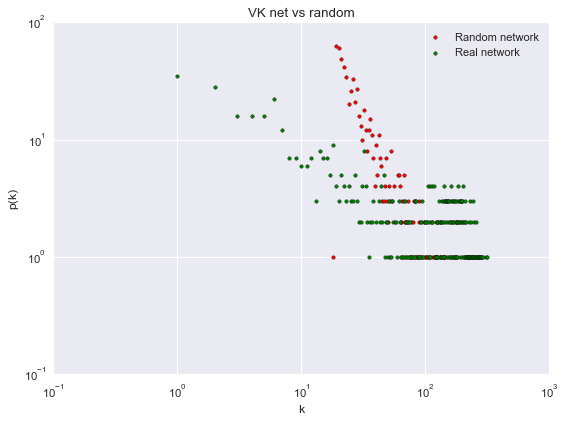

In [442]:
def random_ba_from_real(G):
    n, m = G.number_of_nodes(), G.number_of_edges() // G.number_of_nodes() // 2
    return nx.barabasi_albert_graph(n, m)

plt.figure()
real_net = DG
random_net = random_ba_from_real(real_net)
degree_hist = np.array(nx.degree_histogram(random_net))
idx = np.argwhere(degree_hist > 0)
plt.scatter(idx, degree_hist[idx], s=10, label='Random network', c='r')
degree_hist = np.array(nx.degree_histogram(real_net))
idx = np.argwhere(degree_hist > 0)
plt.scatter(idx, degree_hist[idx], s=10, label='Real network', c='g')
plt.legend()
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('VK net vs BA random')
plt.xscale('log')
plt.yscale('log')
plt.show()